Connecting google drive with colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


giving the path to dataset

In [3]:
import os
#Defining the path to dataset in the drive
base_dir='/content/drive/MyDrive/zip datafiles/dataverse_files'

train_images_part1 = os.path.join(base_dir, 'HAM10000_images_part_1.zip')
train_images_part2 = os.path.join(base_dir, 'HAM10000_images_part_2.zip')
metadata_path = os.path.join(base_dir, 'HAM10000_metadata')

unzipping the files

In [4]:
import zipfile

# Unzipping part 1
with zipfile.ZipFile(train_images_part1, 'r') as zip_ref:
    zip_ref.extractall('/content/HAM10000/part1')

# Unzipping part 2
with zipfile.ZipFile(train_images_part2, 'r') as zip_ref:
    zip_ref.extractall('/content/HAM10000/part2')

reading the data and displaying first few rows

In [5]:
import pandas as pd

metadata_file = os.path.join(base_dir, 'HAM10000_metadata')
metadata = pd.read_csv(metadata_file)
metadata.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear,vidir_modern
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,vidir_modern
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face,vidir_modern
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,vidir_modern
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back,vidir_modern


defining lable path and image path

In [6]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

#Image paths and labels from metadata
image_paths = metadata['image_id'].apply(lambda x: '/content/HAM10000/part1/' + x + '.jpg' if os.path.exists('/content/HAM10000/part1/' + x + '.jpg')
                                          else '/content/HAM10000/part2/' + x + '.jpg')

In [7]:
labels = metadata['dx']

# Encoding labels
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

Preprocessing images  to a uniform size

In [8]:
# Preprocessing images
IMG_SIZE = 128  # Resizing the images to 128x128

def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image.astype('float32') / 255.0  # Normalizing pixel values between 0 and 1
    return image

# Applying preprocessing to all images
images = np.array([preprocess_image(img_path) for img_path in image_paths])

spliting the data into training & testing part

In [9]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

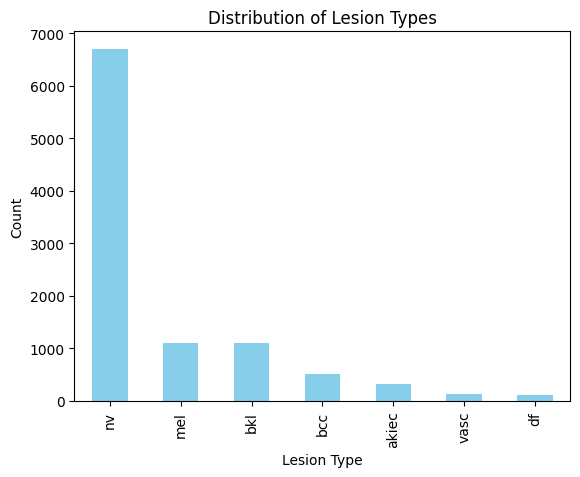

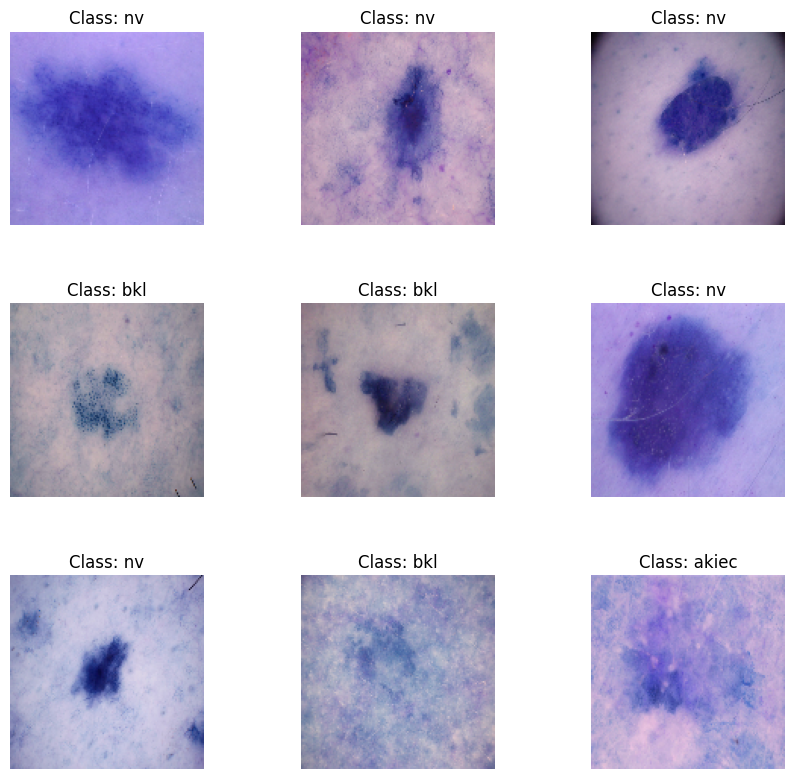

In [10]:
import matplotlib.pyplot as plt

# Plotting distribution of classes
metadata['dx'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Lesion Types')
plt.xlabel('Lesion Type')
plt.ylabel('Count')
plt.show()

# Displaying some sample images with labels
def plot_sample_images(X, y, label_encoder):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.ravel()

    for i in np.arange(0, 9):
        axes[i].imshow(X[i])
        label = label_encoder.inverse_transform([np.argmax(y[i])])[0]
        axes[i].set_title(f"Class: {label}")
        axes[i].axis('off')

    plt.subplots_adjust(wspace=0.5)
    plt.show()

plot_sample_images(X_train, y_train, label_encoder)

In [11]:
# Saving preprocessed arrays
np.save('/content/drive/My Drive/X_train.npy', X_train)
np.save('/content/drive/My Drive/y_train.npy', y_train)
np.save('/content/drive/My Drive/X_test.npy', X_test)
np.save('/content/drive/My Drive/y_test.npy', y_test)

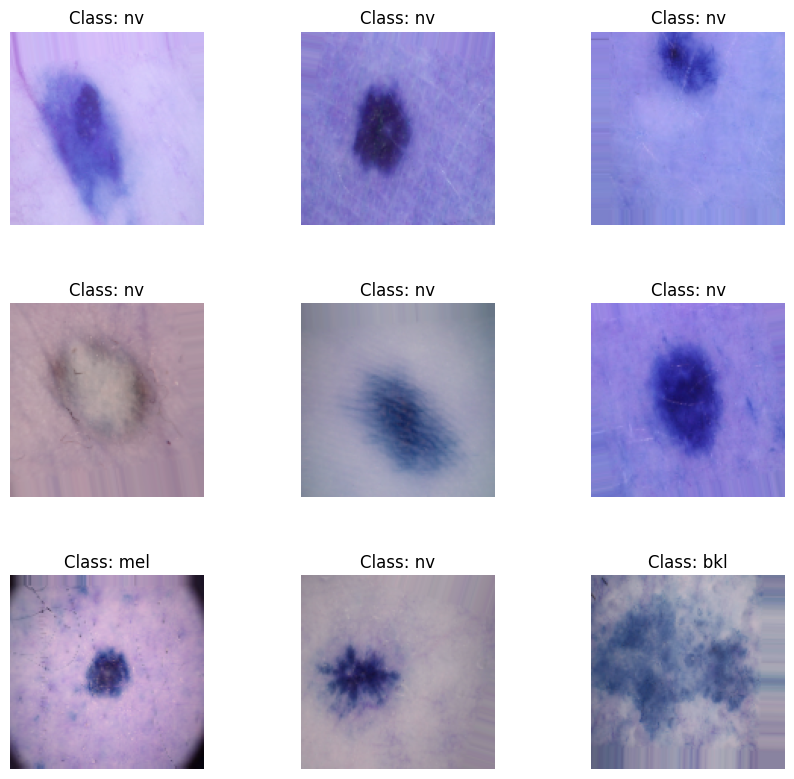

In [31]:
#Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the generator to your training data
datagen.fit(X_train)

# Displaying some augmented images
augmented_images, augmented_labels = next(datagen.flow(X_train, y_train, batch_size=9))

plot_sample_images(augmented_images, augmented_labels, label_encoder)  # Reusing the plot function to visualize

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')  # Output layer with classes from label encoder
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,543 (12.61 MB)

 Trainable params: 3,305,543 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    epochs=40,
                    steps_per_epoch=len(X_train) // 32)

# Save the model after training
model.save('/content/drive/MyDrive/skin_lesion_cnn_model.h5')

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 142ms/step - accuracy: 0.6625 - loss: 1.0833 - val_accuracy: 0.6685 - val_loss: 0.9164
Epoch 2/40
  1/250 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.5312 - loss: 1.1577

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5312 - loss: 1.1577 - val_accuracy: 0.6690 - val_loss: 0.9206
Epoch 3/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 33s 128ms/step - accuracy: 0.6714 - loss: 0.9471 - val_accuracy: 0.6675 - val_loss: 0.8920
Epoch 4/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6250 - loss: 0.8606 - val_accuracy: 0.6680 - val_loss: 0.8819
Epoch 5/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 130ms/step - accuracy: 0.6668 - loss: 0.9305 - val_accuracy: 0.6785 - val_loss: 0.8778
Epoch 6/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8125 - loss: 0.5476 - val_accuracy: 0.6800 - val_loss: 0.8805
Epoch 7/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 130ms/step - accuracy: 0.6785 - loss: 0.8957 - val_accuracy: 0.6720 - val_loss: 0.8525
Epoch 8/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6562 - loss: 0.9737 - val_accuracy: 0.6715 - val_loss: 0.8530
Epoch 9/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 133ms/step - accuracy: 0.6787 - loss: 0.8794 - val_accuracy: 0

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

       akiec       0.50      0.33      0.40        69
         bcc       0.48      0.65      0.55        93
         bkl       0.52      0.36      0.43       228
          df       0.00      0.00      0.00        28
         mel       0.52      0.24      0.33       226
          nv       0.81      0.92      0.86      1338
        vasc       0.35      0.76      0.48        21

    accuracy                           0.73      2003
   macro avg       0.46      0.47      0.44      2003
weighted avg       0.70      0.73      0.71      2003



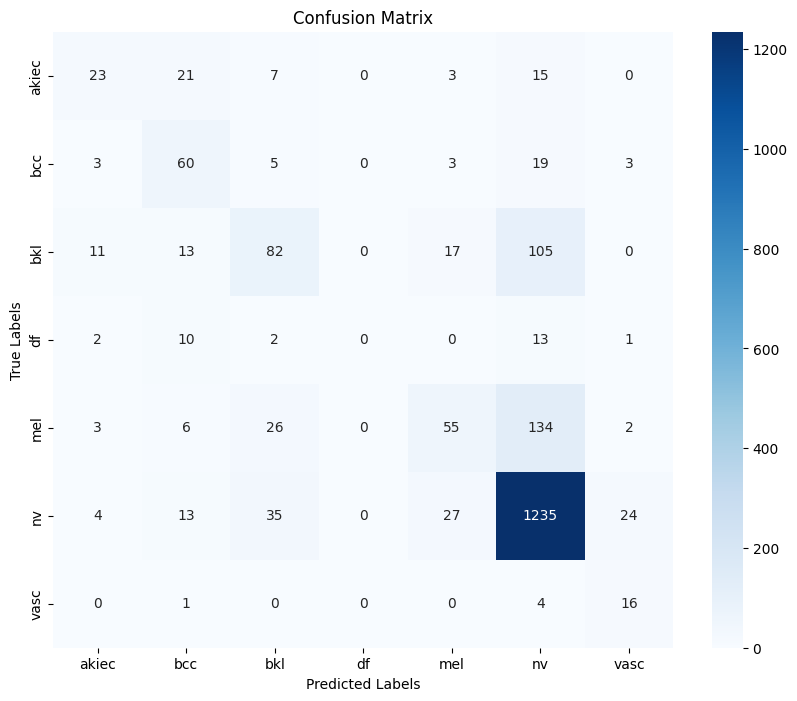

AUC-ROC Score: 0.9144200222642918


In [35]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns

# Load the saved model (if you want to ensure you're testing the right model)
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/skin_lesion_cnn_model.h5')

# Predict on test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Calculate AUC-ROC score
try:
    auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
    print("AUC-ROC Score:", auc)
except ValueError:
    print("AUC-ROC calculation requires binarized labels.")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


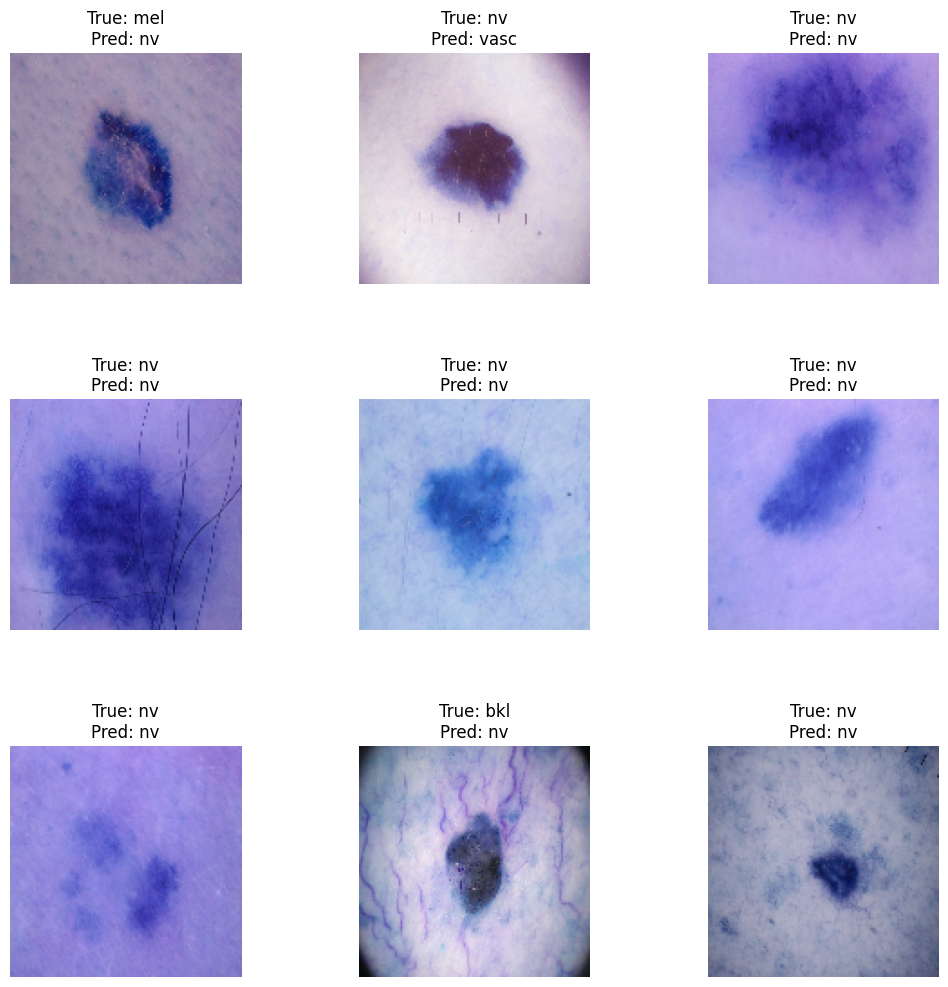

In [36]:
import random

# Function to display images with true and predicted labels
def display_predictions(X, y_true, y_pred, label_encoder, num_images=9):
    indices = random.sample(range(len(X)), num_images)
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.ravel()

    for i, idx in enumerate(indices):
        true_label = label_encoder.inverse_transform([np.argmax(y_true[idx])])[0]
        pred_label = label_encoder.inverse_transform([np.argmax(y_pred[idx])])[0]

        axes[i].imshow(X[idx])
        axes[i].set_title(f"True: {true_label}\nPred: {pred_label}")
        axes[i].axis('off')

    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show()

# Predict labels for the test images
y_pred_prob = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_prob, axis=1)

# Display test images with true and predicted labels
display_predictions(X_test, y_test, y_pred_prob, label_encoder)

#ResNet

In [22]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

# Loading the ResNet50 model with ImageNet weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freezing the base model
base_model.trainable = False

# Adding custom layers
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(label_encoder.classes_), activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [23]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Making the categorical labels back to single integer class labels for class weight calculation
y_train_labels = np.argmax(y_train, axis=1)


class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weights_dict = dict(enumerate(class_weights))

print("Class Weights:", class_weights_dict)

Class Weights: {0: 4.436323366555925, 1: 2.71869697997964, 2: 1.3140888961784485, 3: 13.155993431855501, 4: 1.2903849251087132, 5: 0.2132609332162155, 6: 9.459268004722551}


In [24]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=40,
    steps_per_epoch=len(X_train) // 32,
    class_weight=class_weights_dict  # Adding class weights
)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 61s 189ms/step - accuracy: 0.0883 - loss: 2.0775 - val_accuracy: 0.0140 - val_loss: 1.9544
Epoch 2/40
  1/250 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.0000e+00 - loss: 2.0419

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.0000e+00 - loss: 2.0419 - val_accuracy: 0.0140 - val_loss: 1.9543
Epoch 3/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 39s 155ms/step - accuracy: 0.0337 - loss: 1.8805 - val_accuracy: 0.0344 - val_loss: 1.9510
Epoch 4/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.0312 - loss: 1.5501 - val_accuracy: 0.0140 - val_loss: 1.9512
Epoch 5/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 39s 152ms/step - accuracy: 0.0175 - loss: 1.9319 - val_accuracy: 0.0140 - val_loss: 1.9526
Epoch 6/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0000e+00 - loss: 1.3571 - val_accuracy: 0.0140 - val_loss: 1.9525
Epoch 7/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 39s 152ms/step - accuracy: 0.0135 - loss: 2.0215 - val_accuracy: 0.0140 - val_loss: 1.9483
Epoch 8/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.0000e+00 - loss: 1.9847 - val_accuracy: 0.0140 - val_loss: 1.9483
Epoch 9/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 79s 151ms/step - accuracy: 0.0340 - loss: 1.9872 - 

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
Accuracy: 0.046430354468297554
Classification Report:
               precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        69
         bcc       0.05      1.00      0.09        93
         bkl       0.00      0.00      0.00       228
          df       0.00      0.00      0.00        28
         mel       0.00      0.00      0.00       226
          nv       0.00      0.00      0.00      1338
        vasc       0.00      0.00      0.00        21

    accuracy                           0.05      2003
   macro avg       0.01      0.14      0.01      2003
weighted avg       0.00      0.05      0.00      2003



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


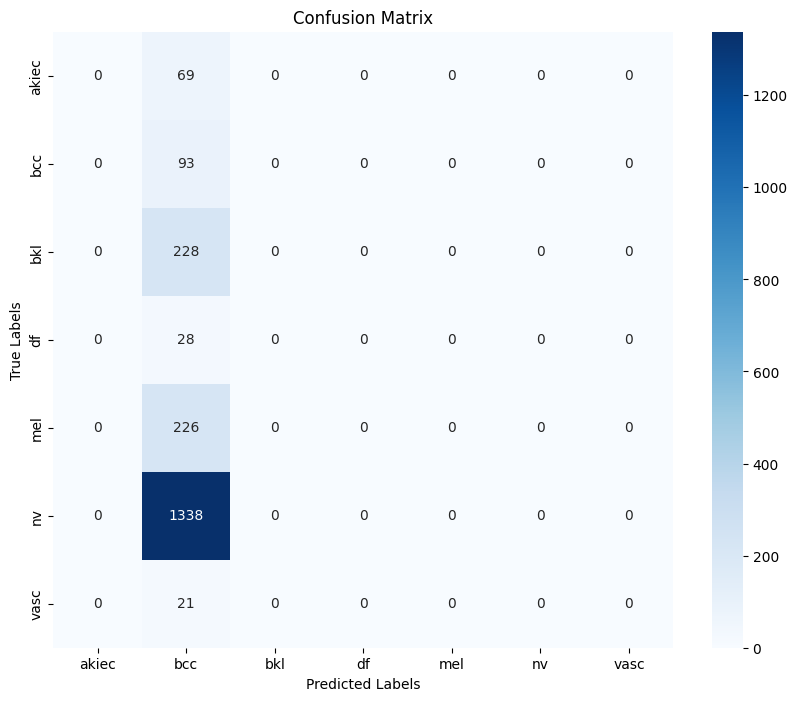

In [26]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import seaborn as sns
# Predicting on test data
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)


accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)


print("Classification Report:\n", classification_report(y_true, y_pred, target_names=label_encoder.classes_))


conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

#VGG

In [27]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Loading VGG16 with pre-trained ImageNet weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [28]:
# Freezing initial layers of the base model
for layer in base_model.layers[:-4]:  # Fine-tune only the last 4 layers
    layer.trainable = False

# Adding custom layers on top of the VGG16 base model
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(label_encoder.classes_), activation='softmax')(x)

# Compiling the model
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate reduction
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-7, verbose=1)

In [29]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=40,
    steps_per_epoch=len(X_train) // 32,
    class_weight=class_weights_dict,  # Applying class weights
    callbacks=[lr_reduction]
)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 64s 210ms/step - accuracy: 0.1680 - loss: 2.0046 - val_accuracy: 0.4838 - val_loss: 1.5336 - learning_rate: 1.0000e-05
Epoch 2/40
  1/250 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.5625 - loss: 2.4613

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.5625 - loss: 2.4613 - val_accuracy: 0.4778 - val_loss: 1.5388 - learning_rate: 1.0000e-05
Epoch 3/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 42s 162ms/step - accuracy: 0.3751 - loss: 1.5731 - val_accuracy: 0.3959 - val_loss: 1.5498 - learning_rate: 1.0000e-05
Epoch 4/40
  1/250 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - accuracy: 0.4375 - loss: 0.9342
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.4375 - loss: 0.9342 - val_accuracy: 0.3974 - val_loss: 1.5544 - learning_rate: 1.0000e-05
Epoch 5/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 73s 150ms/step - accuracy: 0.4720 - loss: 1.3694 - val_accuracy: 0.5806 - val_loss: 1.2401 - learning_rate: 5.0000e-06
Epoch 6/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4375 - loss: 2.1031 - val_accuracy: 0.5746 - val_loss: 1.2549 - learning_rate: 5.0000e-06
Epoch 7/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 80s 152ms/step - accuracy: 0.

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step
Accuracy: 0.5931103344982526
Classification Report:
               precision    recall  f1-score   support

       akiec       0.30      0.65      0.41        69
         bcc       0.35      0.58      0.44        93
         bkl       0.40      0.32      0.36       228
          df       0.11      0.57      0.19        28
         mel       0.32      0.62      0.42       226
          nv       0.95      0.63      0.76      1338
        vasc       0.40      0.95      0.56        21

    accuracy                           0.59      2003
   macro avg       0.40      0.62      0.45      2003
weighted avg       0.75      0.59      0.64      2003



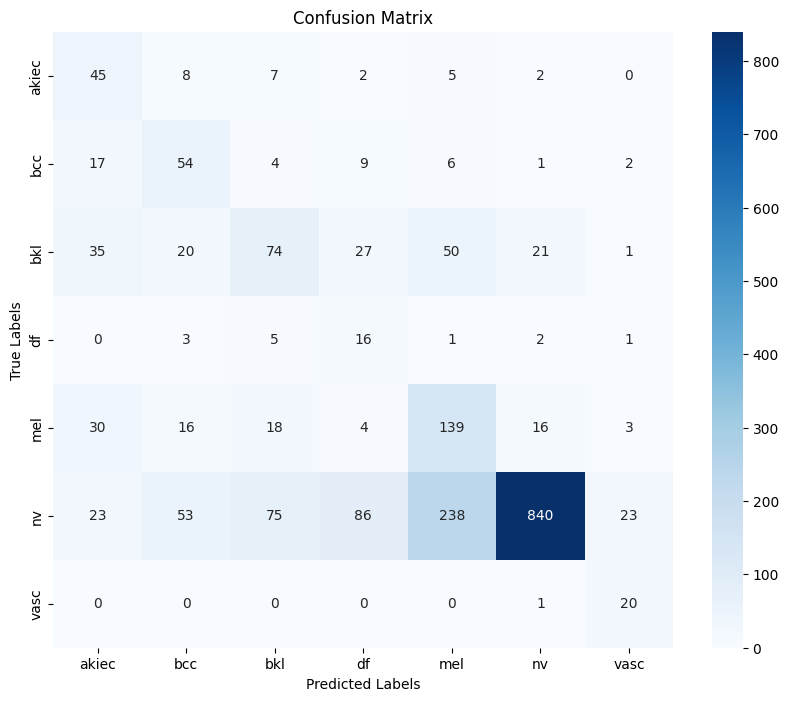

In [30]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import seaborn as sns
# Predicting on test data
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)


accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)


print("Classification Report:\n", classification_report(y_true, y_pred, target_names=label_encoder.classes_))


conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

#EfficientNetB0

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

IMG_SIZE = 128

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(label_encoder.classes_), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Learning rate reduction callback
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-7, verbose=1)

In [ ]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),  # Using data augmentation generator
    validation_data=(X_test, y_test),
    epochs=20,
    steps_per_epoch=len(X_train) // 32,
    class_weight=class_weights_dict,  # Applying class weights for imbalance
    callbacks=[lr_reduction]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 78s 227ms/step - accuracy: 0.1082 - loss: 2.0147 - val_accuracy: 0.0140 - val_loss: 1.9795 - learning_rate: 1.0000e-04
Epoch 2/20
  1/250 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.0938 - loss: 2.2925

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0938 - loss: 2.2925 - val_accuracy: 0.0140 - val_loss: 1.9781 - learning_rate: 1.0000e-04
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 46s 137ms/step - accuracy: 0.0972 - loss: 1.9733 - val_accuracy: 0.0654 - val_loss: 1.9296 - learning_rate: 1.0000e-04
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1562 - loss: 3.2116 - val_accuracy: 0.1128 - val_loss: 1.9319 - learning_rate: 1.0000e-04
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 133ms/step - accuracy: 0.0887 - loss: 2.0172 - val_accuracy: 0.0344 - val_loss: 1.9710 - learning_rate: 1.0000e-04
Epoch 6/20
  1/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.0312 - loss: 1.3654
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0312 - loss: 1.3654 - val_accuracy: 0.0344 - val_loss: 1.9710 - learning_rate: 1.0000e-04
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 39s 131ms/step - accuracy: 0.0752